# Database search with Grover's algorithm using the Sampler primitive

In this tutorial, we will solve an unstructured search problem using Grover's algorithm with the Sampler primitive Qiskit Runtime program.

## 1. Set up your local development environment

This tutorial requires a Qiskit Runtime service instance. If you haven't done so already, follow [these steps](https://cloud.ibm.com/docs/quantum-computing?topic=quantum-computing-quickstart) to set one up.

## 2. Background information

### 2.1 Unstructured search problem

In the olden days, you looked up a person's phone number in a phone book. That is an easy task if you know the person's name because a phone book is orded alphabetically by name. However, the opposite task, that is, you are given a phone number and want to find out who it belongs to, is much more difficult. That is because a phone book is not orded by phone numbers. This is an example of an unstructured search problem. To solve this problem with a classical computer, your best trick is to randomly pick an entry. On average, you will need to look up half of the entires ($N/2$, if $N$ is the total number of entries) to find the owner. If you have a quantum computer, however, you can use Grover's algorithm to find the owner in $\sqrt N$ tries. That means to identify the owner in a phone book that has 1 million numbers, you only need to do 1000 tries instead of 500,000!

### 2.2 Grover's algorithm

In a nutshell, Grover's algorithm uses a nice quantum trick called amplitude amplification to dramatically increase the chances of finding the correct answer - the owner of a phone number - in each try (iteration). That's all we need to know now. We don't have to understand the details about how Grover's algorithm works to apply it, because Qiskit does it for us! However, if you are interested, you can read the chapter about Grover's algorighm in [the Qiskit textbook](https://qiskit.org/textbook/ch-algorithms/grover.html).

Next, let's look at a concrete example.

## 3. Create Grover's circuit

### 3.1 Define an unstructured search problem in Qiskit

In this simple example, you are given a small phone book that has 8 entries, person 0 to person 7, and we want to find the owner of a certain phone number. However, we are not allowed to look at the phone book directly. We are only allowed to consult an 'oracle': a black-box circuit that immediately tells us if our guess is right or wrong (like the Oracle in "The Matrix").

In [1]:
import random
from qiskit.quantum_info import Statevector

secret = random.randint(0,7)  # the owner is randomly picked
secret_string = format(secret, '03b')  # format the owner in 3-bit string
oracle = Statevector.from_label(secret_string)  # let the oracle know the owner

Once we have the oracle, we can define the unstractured search problem using the `AmplificationProblem` class in Qiskit. 

In [2]:
from qiskit.algorithms import AmplificationProblem

problem = AmplificationProblem(oracle, is_good_state=secret_string)

### 3.2 Construct Grover's circuit for the problem

Now we are ready to construct the quantum circuits for Grover's algorithm for this problem. Grover's algorithm's accuracy in finding the correct answer increases with the number of iterations. Let's create a circuit with one and two iterations to see the effect.

In [3]:
from qiskit.algorithms import Grover

grover_circuits = []
grover_circuits_decomposed = []
for iteration in range(1,3):
    grover = Grover(iterations=iteration)
    circuit = grover.construct_circuit(problem)
    circuit.measure_all()
    grover_circuits.append(circuit)
    # decompose circuits
    circuit_decomposed = circuit.decompose().decompose().decompose().decompose()
    grover_circuits_decomposed.append(circuit_decomposed)

Let's look at the circuits:

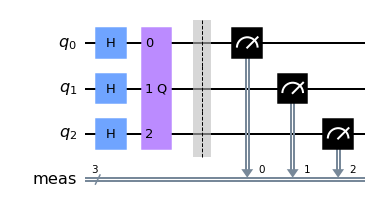

In [4]:
# With 1 iteration
grover_circuits[0].draw()

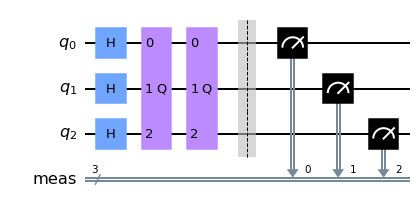

In [5]:
# With 2 iterations
grover_circuits[1].draw()

## 4. Submit the circuits to IBM Cloud

Now that the Grover's circuits are created, let's submit them to a quantum computer on IBM Cloud by using the Sampler program.

### 4.1 Connect to the Qiskit Runtime service 

First, connect to the Qiskit Runtime service instance that you created in [Step 1](#1.-Set-up-your-local-development-environment).

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

Grover's algorithm determines the correct answer based on the highest probability of measurement outcomes. The Sampler program is perfect for getting probabilities, so we will use that.

In [7]:
from qiskit_ibm_runtime import Sampler

with Sampler(circuits=grover_circuits_decomposed) as sampler:
    result = sampler(circuit_indices=[0,1], shots=1000)
    print(result)

SamplerResult(quasi_dists=[{'001': 0.794, '101': 0.024, '110': 0.031, '100': 0.027, '010': 0.044, '000': 0.031, '111': 0.025, '011': 0.024}, {'010': 0.005, '001': 0.953, '101': 0.003, '011': 0.006, '000': 0.007, '111': 0.004, '110': 0.012, '100': 0.01}], metadata=[{'header_metadata': None, 'shots': 1000}, {'header_metadata': None, 'shots': 1000}])


Let's look at the results:

As you can see, the quantum computer returned '001' as the answer with highest probability.  
You can also see that, the probability for getting the right answer is higher with 2 iterations (0.953) than 1 iteration (0.794).


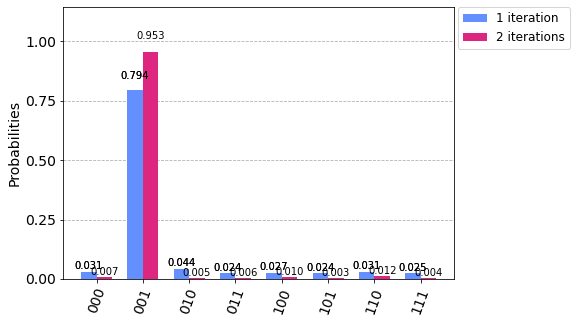

In [8]:
# Plot the results
from qiskit.tools.visualization import plot_histogram

d_iter1 = result.quasi_dists[0]
d_iter2 = result.quasi_dists[1]
highest_prob_iter1 = max(d_iter1.values())
highest_prob_iter2 = max(d_iter2.values())
highest_prob_iter2_key = max(d_iter2, key=d_iter2.get)

print(f"As you can see, the quantum computer returned '{highest_prob_iter2_key}' as the answer with highest probability.  ")
print(f"You can also see that, the probability for getting the right answer is higher with 2 iterations ({highest_prob_iter2}) "
    f"than 1 iteration ({highest_prob_iter1}).")

plot_histogram(result.quasi_dists, legend=['1 iteration', '2 iterations'])

We will print out the quantum result, along with the secret string:

In [9]:
# Print the result and the correct answer.
print(f"Quantum answer: {highest_prob_iter2_key}")
print(f"Correct answer: {secret_string}")
print('Success!' if highest_prob_iter2_key == secret_string else 'Failure!')

Quantum answer: 001
Correct answer: 001
Success!


You can re-run the tutorials a few times to generate other random secret strings to see that we are not cheating! The quantum computer finds the correct answer every time.

In [10]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.3.0'

In [11]:
from qiskit.tools.jupyter import *

%qiskit_version_table
%qiskit_copyright